In [5]:
import os
import numpy as np

# Create a Spark Context
if os.name == 'nt':
    import findspark
    findspark.init(r"D:\Downloads\spark-2.2.1-bin-hadoop2.7")

from pyspark import SparkContext
sc = SparkContext.getOrCreate()


from src.stats import Standardize
from src.preprocess import cleanNHANESData
from src.DBSCAN import DBSCAN
from src.data_handler import Process
from src.data_handler import FeatureVector
from src.preprocess import FilterData
from src.preprocess import ReplaceFeature

raw_data = {}
demo_data={}



for year in ['2005','2007','2009','2011']:
    
    raw_data[year] = sc.textFile('./data/{0}_DR2TOT.csv'.format(year))
        

#Loading the NHANES demographic data of people from 2009 and 2011
for year in ['2005','2007','2009','2011']:
    
    demo_data[year]=sc.textFile('./data/{}_DEMO.csv'.format(year))


# Print total number of food item entries
#for year in['2003','2007','2009''2011']:
#    print(raw_data[year].count(),'count of the nutrient data of the year',year)
#    print(demo_data[year].count(),"count of demo data for year",year)
    
    
total = 0
for year_data in raw_data.values():
    total += year_data.count()
    
total_demo=0   
for year_data in demo_data.values():
    total_demo += year_data.count()
    
#print('Total number of people_nutrient entries: {}'.format(total))
#print('Total number of people_demo entries: {}'.format(total_demo))
#print(raw_data[year].take(2)[0:5])
# Load list of nutrient features we want from the raw dietary data
with open('./data/features.txt') as f:
    features = f.readlines()

features = [f.strip() for f in features]
Feat = features[0:]


with open('./data/features1.txt') as f1:
    features1 = f1.readlines()

features1 = [f.strip() for f in features1]
Feat1 = features1[0:]
# Note that the first 4 features are:
# "USDA food code", "Respondent sequence number", "Modification code", and "Grams"
# The remaining features are micro- and macronutrient features




In [443]:
# Creating a Key Value pair
def _KeyValue(x,size):
    i=0
    key=x[0]
    value=np.array(x[-size:],dtype='float32')
    
    return (key,value)

# Joining the data in different years
def JoinYears(data):
   
    concat_data = 0
    for value in data.values():
        if concat_data == 0:
            concat_data = value
        else:
            concat_data = concat_data.union(value)
       
        
    return concat_data


# Preprocessing the data for Exploratory Data Analysis

def preprocessData(data,features,size):
    #processing data ie remove the header, filling missing values with nan
    for key, rdd in data.items():
        data[key] = Process(rdd)
    
    # Make all headers have same feature names (each year can be different)
    for key, value in data.items():
        header = value[0]
       
        for i, col in enumerate(header):
            header[i] = ReplaceFeature(features, col)
        data[key] = (header, value[1])
    
    
    #Selecting only the features that we need
    for key, value in data.items():
        header,rdd=value
        header,rdd=FeatureVector(rdd, header, features)
        data[key]=(header, rdd)
        
    for key, val in data.items():
        
    
        filt_temp=val[1].filter(lambda x:not any(np.isnan(x)))
        
        tempo= filt_temp.map(lambda x: _KeyValue(x,size))
        data[key]=tempo
       
    data=JoinYears(data)
    
    return data









In [444]:
#cleaning the people's nutrient data
size=len(Feat)-6
preproc_data=preprocessData(raw_data,Feat,size)

#cleaning the people's demographic data
size1=len(Feat1)-1
preproc_demo_data=preprocessData(demo_data,Feat1,size1)
print(preproc_data.take(5),'nutrient data')
print(preproc_demo_data.take(5),'demo data')
print(preproc_data.count(),'is the count of entire nutrients data ')
print(preproc_demo_data.count(),'is the count of entire demographic merged data ')

[(31127.0, array([ 46.11, 165.96, 103.67,   5.6 ,  51.85], dtype=float32)), (31128.0, array([ 94.6 , 158.68,  87.13,   5.5 ,  87.39], dtype=float32)), (31129.0, array([ 79.47, 420.63, 195.93,  19.4 , 125.23], dtype=float32)), (31131.0, array([ 58.33, 239.08, 118.39,   9.9 , 100.15], dtype=float32)), (31132.0, array([ 54.53, 183.59, 109.35,  18.6 ,  42.75], dtype=float32))] nutrient data
[(31127.0, array([0.  , 0.75], dtype=float32)), (31128.0, array([11.  ,  0.77], dtype=float32)), (31129.0, array([15.  ,  2.71], dtype=float32)), (31130.0, array([85.  ,  1.99], dtype=float32)), (31131.0, array([44.  ,  4.65], dtype=float32))] demo data
31763 is the count of entire nutrients data 
37526 is the count of entire demographic merged data 


In [445]:
#If income/poverty ratio is greater than 1 then rich, else poor. 
#sorting based on the income/poverty ratio
def sortRich(rdd2):
    rdd3=[]
    if(rdd2[1][1]>=1): #and rdd2[1][0]>60):
        rdd3.append((rdd2[0],rdd2[1]))
    else:
        #rdd3.append((0,([np.array(0, dtype='float32')])))
        rdd3.append((0,rdd2[1]))
        
    return rdd3
    
def sortPoor(rdd2):
    rdd3=[]
    if(rdd2[1][1]<1): #and rdd2[1][0]>60):
        rdd3.append((rdd2[0],rdd2[1]))
    else:
        rdd3.append((0,rdd2[1]))
        
    return rdd3


rich_rdd=preproc_demo_data.flatMap(sortRich)
poor_rdd=preproc_demo_data.flatMap(sortPoor)
print(rich_rdd.take(5))

#rich=rich_rdd.reduce(lambda x,y:x+y)
print(poor_rdd.take(5))


[(0, array([0.  , 0.75], dtype=float32)), (0, array([11.  ,  0.77], dtype=float32)), (31129.0, array([15.  ,  2.71], dtype=float32)), (31130.0, array([85.  ,  1.99], dtype=float32)), (31131.0, array([44.  ,  4.65], dtype=float32))]
[(31127.0, array([0.  , 0.75], dtype=float32)), (31128.0, array([11.  ,  0.77], dtype=float32)), (0, array([15.  ,  2.71], dtype=float32)), (0, array([85.  ,  1.99], dtype=float32)), (0, array([44.  ,  4.65], dtype=float32))]


In [446]:
#joining the rdd's of nutrient vals and demo to sort poor and rich datasets
#print(preproc_data.take(5),"nutrient data")
print(preproc_data.count())



final_rich_rdd=preproc_data.join(rich_rdd)
#final_rich_rdd1=final_rich_rdd.distinct()
final_poor_rdd=preproc_data.join(poor_rdd)
print(final_rich_rdd.take(5))
print(final_rich_rdd.count())
print(final_poor_rdd.take(5))
print(final_poor_rdd.count())

31763
[(31152.0, (array([ 96.01, 228.64,  71.22,  15.  , 106.33], dtype=float32), array([27.  ,  1.76], dtype=float32))), (31200.0, (array([ 77.7 , 198.83, 163.8 ,  15.9 ,  95.81], dtype=float32), array([1., 5.], dtype=float32))), (31216.0, (array([17.44, 81.36, 62.88,  0.  , 34.56], dtype=float32), array([0. , 3.1], dtype=float32))), (31232.0, (array([ 29.97, 322.89, 180.68,  16.  ,  45.21], dtype=float32), array([56.  ,  1.17], dtype=float32))), (31264.0, (array([ 79.32, 340.66, 166.99,  11.8 ,  75.69], dtype=float32), array([17. ,  3.1], dtype=float32)))]
21839
[(31184.0, (array([10.65, 51.9 , 39.38,  2.2 , 17.15], dtype=float32), array([0.  , 0.41], dtype=float32))), (31296.0, (array([31.61, 71.1 , 18.71,  3.7 , 45.54], dtype=float32), array([4.  , 0.96], dtype=float32))), (31632.0, (array([ 35.41, 136.35,  45.49,  14.1 ,  44.77], dtype=float32), array([2.  , 0.37], dtype=float32))), (31680.0, (array([155.1 , 428.17, 167.01,  30.6 ,  85.1 ], dtype=float32), array([24.  ,  0.53], dt

In [447]:
#processing the data in a way that is feasible to DBSCAN Algorithm to cluster

def sortHere(demordd):
    #demo_list=[]
    #demo_list.append((demordd[0],demordd[1][0]))
    demordd=(demordd[0],demordd[1][0])
    return demordd

rich_nutrient_data=final_rich_rdd.map(sortHere)
poor_nutrient_data=final_poor_rdd.map(sortHere)
print(rich_nutrient_data.take(5))
print(poor_nutrient_data.take(5))

[(31152.0, array([ 96.01, 228.64,  71.22,  15.  , 106.33], dtype=float32)), (31200.0, array([ 77.7 , 198.83, 163.8 ,  15.9 ,  95.81], dtype=float32)), (31216.0, array([17.44, 81.36, 62.88,  0.  , 34.56], dtype=float32)), (31232.0, array([ 29.97, 322.89, 180.68,  16.  ,  45.21], dtype=float32)), (31264.0, array([ 79.32, 340.66, 166.99,  11.8 ,  75.69], dtype=float32))]
[(31184.0, array([10.65, 51.9 , 39.38,  2.2 , 17.15], dtype=float32)), (31296.0, array([31.61, 71.1 , 18.71,  3.7 , 45.54], dtype=float32)), (31632.0, array([ 35.41, 136.35,  45.49,  14.1 ,  44.77], dtype=float32)), (31680.0, array([155.1 , 428.17, 167.01,  30.6 ,  85.1 ], dtype=float32)), (31728.0, array([ 62.94, 273.38, 152.81,  11.9 ,  61.38], dtype=float32))]


In [1]:
#plotting the cluster into 2d 

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
def percentClustered(clusters, total):
    
    total_clusters= clusters.count()
    percentClustered=(total_clusters/total)*100
    return percentClustered
    

def clusterCount(clusters):
    return clusters.values().distinct().count()


data_sample1 = rich_nutrient_data.sample(False, 0.50).persist()
# Projects and plots high dimensional food clusters to a 2D axis
# Input: clusters: RDD <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
# Return: None (shows a plot)
def plotFoodClusters2D(clusters):
    # Get cluster IDS to color plotted clusters
    cluster_ids = clusters.keys().collect()
    unique_ids = np.unique(cluster_ids).tolist()
    cluster_ids = [unique_ids.index(i) for i in cluster_ids]
    
    # Reduce nutrient values to 2 dimensions with TSNE
    # HINT: ref [1,2]
    nutrient_values = clusters.values().collect()
    cluster_embedded = TSNE(n_components=2).fit_transform(nutrient_values)
    
    # Plot clusters
    X = cluster_embedded[:,0]
    Y = cluster_embedded[:,1]
    plt.scatter(X, Y, c=cluster_ids, s=3)
    plt.show()
    plt.clf()
    
    
# Define your values for epsilon and min_pts
epsilon = 15
min_pts = 4
metric = 'euclidean'

# Cluster the food items with your parameters and DBSCAN
food_clusters = DBSCAN(sc,data_sample1, epsilon=epsilon, minpts=min_pts, metric=metric)
food_clusters1 = DBSCAN(sc,poor_nutrient_data, epsilon=epsilon, minpts=min_pts, metric=metric)
# Combine cluster ID with nutrient value
# RDD is now << (food ID, (cluster ID, [nutrient, values])), (food ID, (cluster ID, [nutrient, values])), ...>>
cluster_data = food_clusters.join(data_sample1)
cluster_data1 = food_clusters1.join(poor_nutrient_data)


# Isolate cluster ID and nutrient value (i.e., get rid of food item ID)
# RDD should be <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
cluster_nutrient = cluster_data.values()
cluster=cluster_data1.values()

# Plot clusters in 2D projected space and report cluster information
plotFoodClusters2D(cluster_nutrient)
plotFoodClusters2D(cluster)
perc_clust = percentClustered(food_clusters,data_sample.count())
clust_cnt = clusterCount(food_clusters)
print('{} Clusters found with {:.2f} % food items clustered'.format(clust_cnt, perc_clust))

perc_clust1 = percentClustered(food_clusters1,poor_nutrient_data.count())
clust_cnt1 = clusterCount(food_clusters1)
print('{} Clusters found with {:.2f} % food items clustered'.format(clust_cnt1, perc_clust1))

NameError: name 'rich_nutrient_data' is not defined

[array([ 96.01, 228.64,  71.22,  15.  , 106.33], dtype=float32), array([ 77.7 , 198.83, 163.8 ,  15.9 ,  95.81], dtype=float32), array([17.44, 81.36, 62.88,  0.  , 34.56], dtype=float32), array([ 29.97, 322.89, 180.68,  16.  ,  45.21], dtype=float32), array([ 79.32, 340.66, 166.99,  11.8 ,  75.69], dtype=float32)]
For people above poverty line macro-nutrient consumption in grams:
Average protein consumption: 74.17172
Average carbohydrate consumption: 240.42401
Average fat consumption: 70.5823
Average sugar consumption: 110.6146
Average fiber consumption: 15.2741785
For people below poverty line macro-nutrient consumption in grams:
Average protein consumption: 67.72578
Average carbohydrate consumption: 229.32776
Average fat consumption: 65.06882
Average sugar consumption: 108.63567
Average fiber consumption: 13.17736
[67.72578, 229.32776, 108.63567, 13.17736, 65.06882]


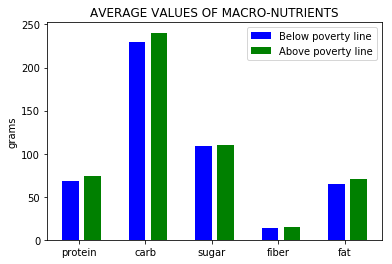

In [448]:
#statistics about average carbs and protein
def addValues(val1, val2):
    return val1 + val2


rich_stat_rdd=rich_nutrient_data.flatMap(lambda x: x[1:])
print(rich_stat_rdd.take(5))
rich=rich_stat_rdd.reduce(addValues)
average_rich=rich/rich_stat_rdd.count()
#print(rich_stat_rdd.count())
print("For people above poverty line macro-nutrient consumption in grams:")
print("Average protein consumption:",average_rich[0])
print("Average carbohydrate consumption:",average_rich[1])
print("Average fat consumption:",average_rich[4])
print("Average sugar consumption:",average_rich[2])
print("Average fiber consumption:",average_rich[3])

#For people below poverty line
poor_stat_rdd=poor_nutrient_data.flatMap(lambda x: x[1:])
#print(rich_stat_rdd.take(5))
poor=poor_stat_rdd.reduce(addValues)
average_poor=poor/poor_stat_rdd.count()
#print(rich_stat_rdd.count())
print("For people below poverty line macro-nutrient consumption in grams:")
print("Average protein consumption:",average_poor[0])
print("Average carbohydrate consumption:",average_poor[1])
print("Average fat consumption:",average_poor[4])
print("Average sugar consumption:",average_poor[2])
print("Average fiber consumption:",average_poor[3])

bar_list=[]
for i in range(0,5):
    
    bar_list.append(average_poor[i])
print(bar_list)

bar_list1=[]
for i in range(0,5):
    bar_list1.append(average_rich[i])
    

def barPlot(bar_list,bar_list1):
    ind=np.arange(5)
    width=0.25
    fig=plt.figure()
    ax=fig.add_subplot(111)
    rects1=ax.bar(ind,bar_list,width,color='blue')
    rects2=ax.bar(ind+width+0.08,bar_list1,width,color='green')
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('protein','carb','sugar','fiber','fat'))
    ax.set_title("AVERAGE VALUES OF MACRO-NUTRIENTS")
    ax.set_ylabel("grams")
    ax.legend((rects1[0],rects2[0]),('Below poverty line','Above poverty line'))
    plt.show()

barPlot(bar_list,bar_list1)


In [450]:
#More stats:

def checkSugar(rdd):
    count=0
    count2=0
    protein=0
    carbs=0
    if(rdd[2]>120):
        count+=1
    if(rdd[4]>100):
        count2+=1
    if(rdd[0]<56):
        protein+=1
    if(rdd[1]<210):
        carbs+=1
    c=np.array((count,count2,protein,carbs))
    return c

totsugfat=rich_stat_rdd.map(checkSugar)

totsugfat1=poor_stat_rdd.map(checkSugar)
#print(totsugfat.take(5))

sugar_sum=totsugfat.reduce(addValues)
sugar_sum1=totsugfat1.reduce(addValues)
percent=sugar_sum1[0]*100/poor_stat_rdd.count()  # sugar poor
percent_rich=sugar_sum[0]*100/rich_stat_rdd.count() #sugar rich
percent_rich_fat=sugar_sum[1]*100/rich_stat_rdd.count() #fat rich
percent_poor_fat=sugar_sum1[1]*100/poor_stat_rdd.count()

########deficit
percent_protein=sugar_sum1[2]*100/poor_stat_rdd.count()  # protien deficit poor
percent_proteinrich=sugar_sum[2]*100/rich_stat_rdd.count()  #protein deficit rich

percent_rich_carbs=sugar_sum[3]*100/rich_stat_rdd.count() #carbs defi rich
percent_poor_carbs=sugar_sum1[3]*100/poor_stat_rdd.count() #carbs defi poor  



print(percent_rich,'percent of people eating dangerous amount of sugars')
print(percent_rich_fat,'percent of people eating dangerous amount of fat')

print("\nfor the people below poverty line\n")
print(percent,'percent of people eating dangerous amount of sugars')
print(percent_poor_fat,'percent of people eating dangerous amount of fat')

print("deficit")
print(percent_protein,"protien deficit in poor" )

print(percent_proteinrich,"protien deficit in rich" )
print(percent_poor_carbs,"carbs deficit in poor" )
print(percent_rich_carbs,"carbs deficit in rich" )



35.90823755666468 percent of people eating dangerous amount of sugars
18.984385731947434 percent of people eating dangerous amount of fat

for the people below poverty line

34.1182559192651 percent of people eating dangerous amount of sugars
15.34480527882003 percent of people eating dangerous amount of fat
deficit
42.864536162504855 protien deficit in poor
35.578552131507855 protien deficit in rich
50.291111398628544 carbs deficit in poor
44.97458674847749 carbs deficit in rich


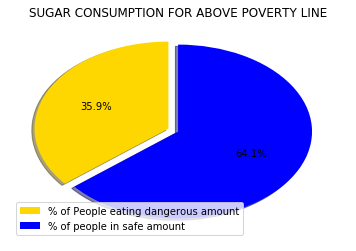

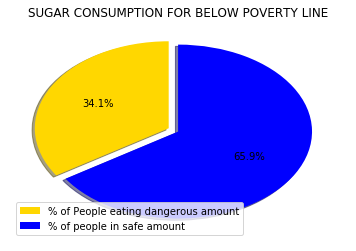

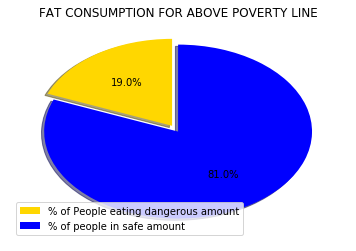

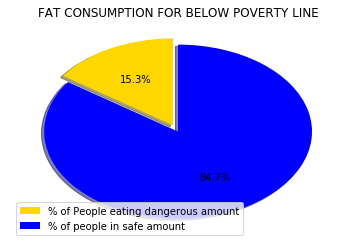

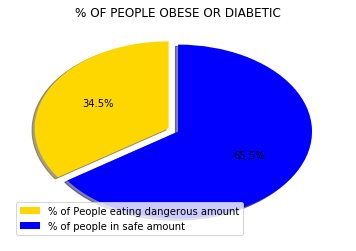

In [451]:
from scipy.stats import normaltest
from pyspark.mllib.clustering import KMeans

def pieChart(percent,title=''):
    stats=[]
    stats.append(percent)
    stats.append(100-percent)
    #print(stats)
    colors=['gold','blue']
    explode=(0.08,0)
    labels=['% of People eating dangerous amount','% of people in safe amount']
    plt.pie(stats,explode=explode,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90) 
    plt.legend(labels,loc='best')
    plt.title(title)
    plt.show()    
    
pieChart(percent_rich,'SUGAR CONSUMPTION FOR ABOVE POVERTY LINE')   
pieChart(percent,'SUGAR CONSUMPTION FOR BELOW POVERTY LINE')

pieChart(percent_rich_fat,"FAT CONSUMPTION FOR ABOVE POVERTY LINE")
pieChart(percent_poor_fat,"FAT CONSUMPTION FOR BELOW POVERTY LINE")

obese=34.5
pieChart(obese,"% OF PEOPLE OBESE OR DIABETIC")


    
#normalizing and k-means:

#k=rich_nutrient_data.mapValues(lambda x: x[1:]/x[0])
#print(k.take(5))
#final_rich=Standardize(k)
#print(final_rich.take(5))

#K-means clustering:
#print(rich_stat_rdd.take(5))

def carbFat(rdd):
    rdd=np.array((rdd[1],rdd[4]))
    return rdd
    

kmean=rich_stat_rdd.map(carbFat)
kmean_poor=poor_stat_rdd.map(carbFat)
#print(kmean.take(5))
#print(kmean.count())

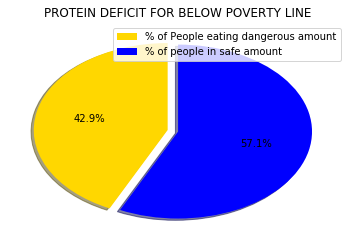

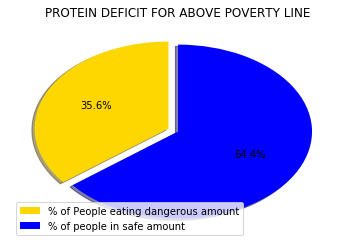

In [452]:
#deficit piechart


pieChart(percent_protein,"PROTEIN DEFICIT FOR BELOW POVERTY LINE")

pieChart(percent_proteinrich,"PROTEIN DEFICIT FOR ABOVE POVERTY LINE")



9882
7729
[array([129.10482752,  44.38522568]), array([550.63941118, 146.2125688 ]), array([350.3947955 ,  99.41431364]), array([231.54182072,  67.67833249])]


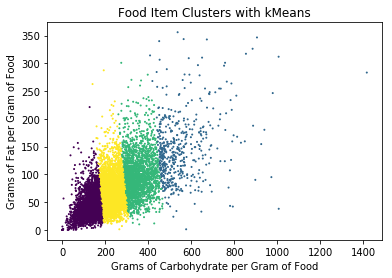

[array([291.01028657,  79.93541123]), array([478.34215772, 126.90298021]), array([184.29720589,  53.73470842]), array([96.38541145, 32.96033155])]


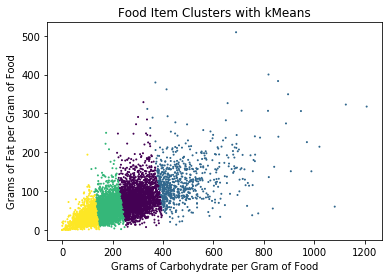

In [453]:
def plotFoodClusters(data, cluster_ids):
    # Plot the clusters with a scatter plot
    
    data = np.array(data.collect())
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, s=1)
    # Define axis labels and plot title
    plt.xlabel('Grams of Carbohydrate per Gram of Food')
    plt.ylabel('Grams of Fat per Gram of Food')
    plt.title('Food Item Clusters with kMeans')
    plt.show()
    plt.clf()



def clusterAndPlotData(data, K):
    # Cluster food items using kMeans and input K value
    K=4
    
    model = KMeans.train(data, K, maxIterations=10, initializationMode='random')
    
    cluster_ID=model.predict(data).collect()
    print(model.clusterCenters)
    # Get the cluster ID for each food item in the dataset.  
    # Cluster ID values are used to show clusters with color in plots
    #print(cluster_ids.take(20))
    
    # Plot food clusters
    plotFoodClusters(data,cluster_ID)


# Define the optimal K value you found above.  It will be used for the remainder of the assignment!
K = 4
#print(data_values.take(5))
kmean1=kmean.sample(False,0.45).persist()
print(kmean1.count())
print(kmean_poor.count())
# Cluster and plot food items from ./data/data-1.csv
clusterAndPlotData(kmean1, 4)
clusterAndPlotData(kmean_poor,4)
#clusterAndPlotData(new_data, K)